In this notebook we create an effective PSF at which to model galaxy morphologies,
and we use an isotropic Hanning window for that purpose

In [3]:
%pylab inline
import galsim
from scipy.signal.windows import hann

Populating the interactive namespace from numpy and matplotlib


In [11]:
# We draw the PSF image in Kspace at the correct resolution
N = 64
im_scale = 0.168
interp_factor=6 # This is how much sub sampling is required to
                # reach the band limit of HST COSMOS image
padding_factor=2
Nk = N*interp_factor*padding_factor
from galsim.bounds import _BoundsI
bounds = _BoundsI(0, Nk//2, -Nk//2, Nk//2-1)

In [32]:
# Hann window
stamp_size = Nk
target_pixel_scale=im_scale
pixel_scale=im_scale/interp_factor
my_psf = np.zeros((stamp_size,stamp_size))
for  i in range(stamp_size):
    for j in range(stamp_size):
        r = sqrt((i - 1.0*stamp_size//2)**2 + (j-1.0*stamp_size//2)**2)/(stamp_size//2)*pi/2*target_pixel_scale/pixel_scale
        my_psf[i,j] = sin(r+pi/2)**2
        if r >= pi/2:
            my_psf[i,j] = 0
            
# Export the PSF as a galsim object, truncating it to save some ressources
my_psf = my_psf[315:-315,315:-315]
effective_psf = galsim.InterpolatedKImage(galsim.ImageCD(my_psf+0*1j, scale=2.*np.pi/(Nk * im_scale / interp_factor )))

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


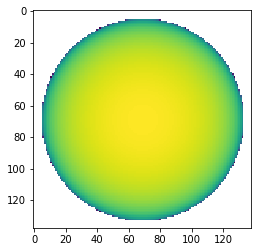

In [33]:
imshow(log10(my_psf));

In [34]:
from astropy.io import fits
# Exporting the effective PSF
fits.writeto('../data/hsc_hann_window.fits', my_psf, clobber=True)

In [37]:
print("This is the k scale of this image", 2.*np.pi/(Nk * im_scale / interp_factor ))

0.2921868167401221


In [35]:
data_dir='/usr/local/share/galsim/COSMOS_25.2_training_sample'
stamp_size=64
pixel_scale=0.168
cat = galsim.COSMOSCatalog(dir=data_dir)

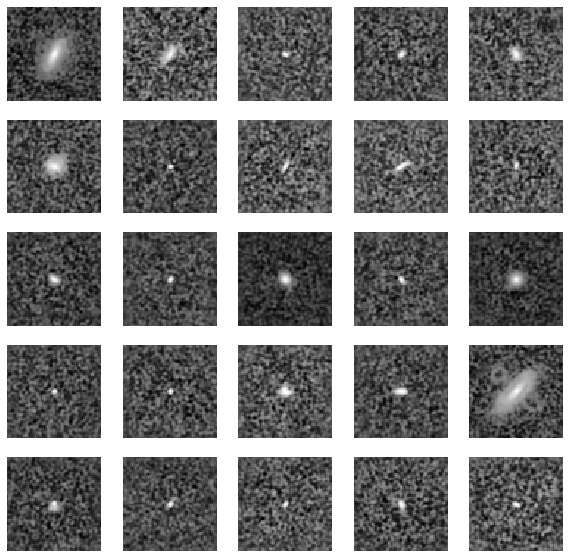

In [36]:
figure(figsize=(10,10))
c = 0
for i in range(25):
    gal = cat.makeGalaxy(i+9, noise_pad_size=64 * 0.168)
    g = galsim.Convolve(gal, effective_psf)
    imgal = g.drawImage(nx=stamp_size, ny=stamp_size, scale=pixel_scale, 
                        method='no_pixel', use_true_center=False)
    subplot(5,5,c+1)
    imshow(arcsinh(50*imgal.array),cmap='gray')
    axis('off')
    c+=1